In [1]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
from torchvision.utils import save_image
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Mounted at /content/drive


In [2]:
import os
import shutil
from PIL import Image
import numpy as np

# def filter_images_by_size_percentile(
#     input_folder: str,
#     output_folder: str,
#     lower_percentile: float = 10,
#     upper_percentile: float = 90
# ):
#     """
#     Filters images in input_folder based on pixel size percentiles and saves them to output_folder.

#     Parameters:
#     - input_folder (str): Path to the source image folder.
#     - output_folder (str): Path to save filtered images.
#     - lower_percentile (float): Lower size percentile cutoff (e.g., 10).
#     - upper_percentile (float): Upper size percentile cutoff (e.g., 90).
#     """
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     image_files = [
#         f for f in os.listdir(input_folder)
#         if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))
#     ]

#     image_sizes = []
#     size_map = {}

#     for fname in image_files:
#         fpath = os.path.join(input_folder, fname)
#         try:
#             with Image.open(fpath) as img:
#                 width, height = img.size
#                 size = width * height
#                 image_sizes.append(size)
#                 size_map[fname] = size
#         except Exception as e:
#             print(f"Error reading {fname}: {e}")

#     if not image_sizes:
#         print("No valid images found.")
#         return

#     # Compute thresholds
#     lower = np.percentile(image_sizes, lower_percentile)
#     upper = np.percentile(image_sizes, upper_percentile)

#     print(f"Keeping images with sizes between {int(lower)} and {int(upper)} pixels.")

#     # Filter and copy
#     for fname, size in size_map.items():
#         if lower <= size <= upper:
#             shutil.copy(os.path.join(input_folder, fname), os.path.join(output_folder, fname))

#     print(f"Filtered images saved to: {output_folder}")
# filter_images_by_size_percentile(
#     input_folder="/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27",
#     output_folder="/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27_middle60",
#     lower_percentile=20,
#     upper_percentile=80
# )


📊 TRAIN SET SUMMARY:
Total cases: 38
  Case 98: 256 patches (Label: High-grade)
  Case 70: 44 patches (Label: High-grade)
  Case 42: 86 patches (Label: High-grade)
  Case 91: 15 patches (Label: High-grade)
  Case 55: 274 patches (Label: High-grade)
  Case 83: 963 patches (Label: High-grade)
  Case 84: 533 patches (Label: High-grade)
  Case 73: 584 patches (Label: High-grade)
  Case 48: 300 patches (Label: High-grade)
  Case 80: 224 patches (Label: High-grade)
  Case 88: 53 patches (Label: High-grade)
  Case 40: 190 patches (Label: High-grade)
  Case 53: 170 patches (Label: Benign)
  Case 78: 76 patches (Label: Benign)
  Case 96: 161 patches (Label: Benign)
  Case 12: 100 patches (Label: High-grade)
  Case 19: 147 patches (Label: High-grade)
  Case 100: 114 patches (Label: High-grade)
  Case 32: 143 patches (Label: High-grade)
  Case 46: 16 patches (Label: Benign)
  Case 50: 314 patches (Label: High-grade)
  Case 45: 34 patches (Label: Benign)
  Case 93: 78 patches (Label: Benign)
  Ca

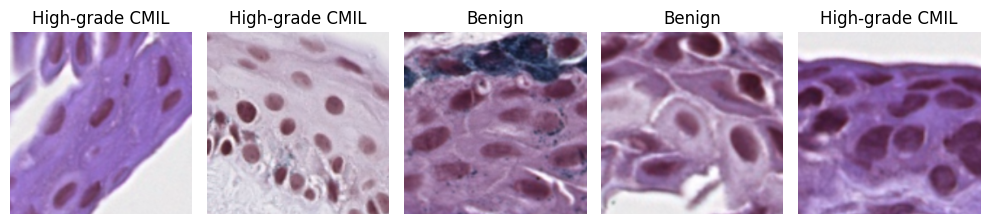

✅ Saved image paths and labels:
{'path': '/content/drive/My Drive/attention_patches_H&E_Middle_Percentile/patch_0_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_H&E_Middle_Percentile/patch_1_label_1.png', 'label': 1}
{'path': '/content/drive/My Drive/attention_patches_H&E_Middle_Percentile/patch_2_label_0.png', 'label': 0}
{'path': '/content/drive/My Drive/attention_patches_H&E_Middle_Percentile/patch_3_label_0.png', 'label': 0}
{'path': '/content/drive/My Drive/attention_patches_H&E_Middle_Percentile/patch_4_label_1.png', 'label': 1}


In [3]:
# Add labels to each patch and match by their case, randomly split patients into training, validation, and testing sets

labels = pd.read_csv('/content/drive/My Drive/case_grade_match.csv') # Replace with the path to file

# Define a function to group patches by case number
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

# Define a custom dataset class for loading PNG images
class PNGDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None):
        self.case_patches = case_patches
        self.labels_df = labels_df
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Label benign images 0, and high-grade CMIL images 1
        for case_num, patches in case_patches.items():
            label = labels_df.loc[labels_df['Case'] == case_num, 'Class'].values[0]
            label = 0 if label == 1 else 1
            for patch_path in patches:
                self.image_paths.append(patch_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Get patch images
        image = Image.open(image_path).convert('RGB')
        # Get the label information using the labels dataframe based on case number
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Resize all patch images to 256x256
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Possible data augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder_path = '/content/drive/MyDrive/filtered_patches_SP2025_h&e_Apr27_middle60' # Replace with the path to filtered patches
patches = group_patches(image_folder_path)

# Get case numbers and their labels
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]

# Remove those that are equal to 2 (not classifying low-grade CMIL images currently)
noindex = ~dataset.Class.isin([0.0, 2.0])
X = dataset[noindex].Case
y = dataset[noindex].Class

# Ensure X and y have the same length before splitting
X = X.reset_index(drop=True)  # Reset index to avoid potential issues
y = y.reset_index(drop=True)  # Reset index to avoid potential issues

# Split the data into train, test, and validation sets
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# Create the training, validation, and testing patches
train_patches = {case_num: patches[int(case_num)] for case_num in train_X} # Use train_X
val_patches = {case_num: patches[int(case_num)] for case_num in val_X} # Use val_X
test_patches = {case_num: patches[int(case_num)] for case_num in test_X} # Use test_X

def summarize_case_patches(split_name, split_dict, labels_df):
    print(f"\n📊 {split_name.upper()} SET SUMMARY:")
    print(f"Total cases: {len(split_dict)}")
    total_patches = benign_patches = high_grade_patches = unknown_cases = 0

    for case_num, patch_list in split_dict.items():
        num_patches = len(patch_list)
        total_patches += num_patches
        label_row = labels_df[labels_df['Case'] == int(case_num)]
        if label_row.empty:
            unknown_cases += 1
            continue
        original_label = label_row['Class'].values[0]
        label = 0 if original_label == 1 else 1
        if label == 0:
            benign_patches += num_patches
        else:
            high_grade_patches += num_patches
        print(f"  Case {case_num}: {num_patches} patches (Label: {'Benign' if label == 0 else 'High-grade'})")

    print(f"Total patches: {total_patches}")
    print(f"  Benign patches: {benign_patches}")
    print(f"  High-grade patches: {high_grade_patches}")
    if unknown_cases:
        print(f"  ⚠️ {unknown_cases} cases missing labels")

summarize_case_patches("train", train_patches, labels)
summarize_case_patches("val", val_patches, labels)
summarize_case_patches("test", test_patches, labels)


# Create PNGDataset instances for train, validation, and test
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=transform)
test_dataset = PNGDataset(test_patches, labels, transform=transform)

# Create DataLoaders using the PNGDataset instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Shuffle validation data ### I DONT THINK THIS IS NEEDED
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Do not shuffle test data

# Step 1: Get one batch from the train_loader
images, labels = next(iter(train_loader))

# Step 2: Select the first 5 images and labels
selected_images = images[:5]
selected_labels = labels[:5]

# Step 3: Save folder for images
save_dir = '/content/drive/My Drive/attention_patches_H&E_Middle_Percentile'
os.makedirs(save_dir, exist_ok=True)

# Step 4: Denormalization function (to convert back to displayable format)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Step 5: Save images and visualize them
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)

for i in range(5):
    # Denormalize the tensor for visualization/saving
    denorm_img = denormalize(selected_images[i].clone())

    # Save image tensor as PNG
    img_path = os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png')
    save_image(denorm_img, img_path)

    # Display the image
    img_np = denorm_img.permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    axes[i].imshow(img_np)
    axes[i].set_title('Benign' if selected_labels[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Step 6: Optional - save metadata (image path and label) for future reference
saved_patch_info = [
    {"path": os.path.join(save_dir, f'patch_{i}_label_{selected_labels[i].item()}.png'),
     "label": selected_labels[i].item()}
    for i in range(5)
]

print("✅ Saved image paths and labels:")
for info in saved_patch_info:
    print(info)


In [4]:
def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in iter(val_loader):
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item() * images.size(0)  # Scale by batch size

            _, preds = torch.max(output, dim=1)
            correct = (preds == labels).sum().item()
            correct_total += correct
            sample_total += labels.size(0)

    accuracy = correct_total / sample_total
    val_loss /= sample_total  # Now compute the proper average
    return val_loss, accuracy
  # Define training loop

# ---------- Checkpoint Save Function ----------
def save_checkpoint(model, arch, checkpoint_dir, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"

    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }

    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

# ---------- Training Function ----------
def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5, start_epoch=0):
    plot_training = []
    plot_validation = []

    for e in range(start_epoch, start_epoch + epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        validation_loss, accuracy = validation(model, criterion, val_loader)

        print(
            f"Epoch: {e + 1}/{epochs}.. "
            f"Training Loss: {epoch_loss:.3f}.. "
            f"Validation Loss: {validation_loss:.3f}.. "
            f"Validation Accuracy: {accuracy:.3f}"
        )

        plot_training.append(epoch_loss)
        plot_validation.append(validation_loss)

        # Save checkpoint
        save_checkpoint(model, arch, checkpoint_dir, epoch=e + 1)

    # Plot training & validation loss
    plt.plot(range(1, epochs + 1), plot_training, label='Training Loss')
    plt.plot(range(1, epochs + 1), plot_validation, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    return model

In [5]:
import timm
import torch.nn as nn
import os

# Create DeiT-small model
model = timm.create_model(
    'deit_small_patch16_224',  # or 'deit_base_patch16_224'
    pretrained=True,           # Start from ImageNet weights
    num_classes=2              # Binary or multi-class
)

arch = "deit_small_patch16_224_H&E_subset"

checkpoint_dir = "/content/drive/My Drive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

num_classes = 2
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, num_classes)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze just the classifier head
for param in model.head.parameters():
    param.requires_grad = True

# Confirm the classifier
print("\nModified DeiT classifier head:")
print(model.head)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Modified DeiT classifier head:
Linear(in_features=384, out_features=2, bias=True)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-4)

Epoch: 1/5.. Training Loss: 0.637.. Validation Loss: 0.646.. Validation Accuracy: 0.590
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250521_062846_deit_small_patch16_224_H&E_subset_epoch1.pth
Epoch: 2/5.. Training Loss: 0.497.. Validation Loss: 0.612.. Validation Accuracy: 0.634
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250521_070749_deit_small_patch16_224_H&E_subset_epoch2.pth
Epoch: 3/5.. Training Loss: 0.460.. Validation Loss: 0.584.. Validation Accuracy: 0.671
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250521_074625_deit_small_patch16_224_H&E_subset_epoch3.pth
Epoch: 4/5.. Training Loss: 0.435.. Validation Loss: 0.582.. Validation Accuracy: 0.672
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250521_082517_deit_small_patch16_224_H&E_subset_epoch4.pth
Epoch: 5/5.. Training Loss: 0.420.. Validation Loss: 0.536.. Validation Accuracy: 0.730
✅ Checkpoint saved: /content/drive/My Drive/checkpoints/20250521_090323_deit_small_patch16_2

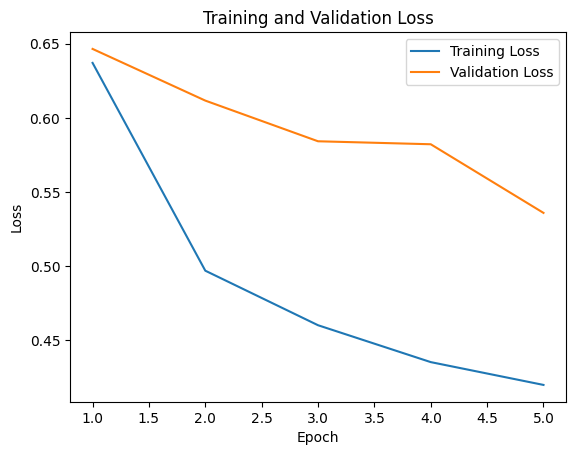

In [7]:
resnet_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch=arch,
    checkpoint_dir=checkpoint_dir,
    epochs=5,            # how many *more* epochs to train
    start_epoch=0  # where you left off
)

In [8]:
model.eval()

with torch.no_grad():
    predictions = []
    true_labels = []

    for images, labels in iter(test_loader):
        output = model.forward(images)
        probabilities = torch.exp(output)
        predictions += probabilities.max(dim=1)[1].tolist()
        true_labels += labels.tolist()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.69      0.42      0.52       939
           1       0.65      0.85      0.74      1198

    accuracy                           0.66      2137
   macro avg       0.67      0.64      0.63      2137
weighted avg       0.67      0.66      0.64      2137



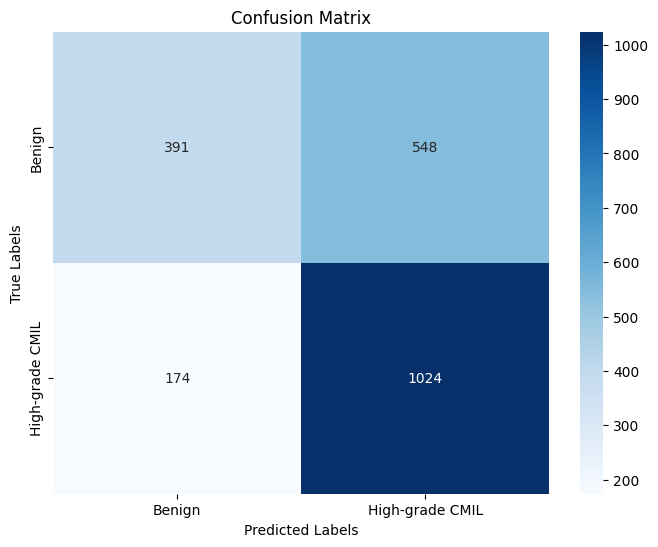

In [9]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Get accuracies for individual cases in the test set

case_predictions = {}
case_true_labels = {}
case_accuracies = {}

# Create a dictionary to map image paths to case numbers
image_to_case = {}
for case_num, patches in test_patches.items():
    for patch in patches:
        image_to_case[patch] = case_num

# Iterate through the test dataset to map predictions back to case numbers
for i in range(len(test_dataset)):
    image_path, label = test_dataset[i]  # Access the image path and label directly from the dataset
    case_num = image_to_case[test_dataset.image_paths[i]]  # Use the image path to find the case number
    prediction = predictions[i]  # Access the prediction directly from the prediction list

    if case_num not in case_predictions:
        case_predictions[case_num] = []
        case_true_labels[case_num] = []
    case_predictions[case_num].append(prediction)
    case_true_labels[case_num].append(label)

for case_num, preds in case_predictions.items():
    correct_count = sum(1 for p, t in zip(preds, case_true_labels[case_num]) if p == t)
    accuracy = (correct_count / len(preds)) if len(preds) > 0 else 0  # Avoid division by zero
    case_accuracies[case_num] = accuracy

# Print the results
for case_num, accuracy in case_accuracies.items():
    true_label = case_true_labels[case_num][0]  # Get the true label for the case (all labels should be the same for a single case)
    true_label_name = 'Benign' if true_label == 0 else 'High-grade CMIL'  # Convert to label name
    print(f"Case {case_num}: Accuracy = {accuracy:.4f}, True Label = {true_label_name}")

Case 95: Accuracy = 0.9796, True Label = High-grade CMIL
Case 86: Accuracy = 0.2299, True Label = Benign
Case 57: Accuracy = 0.9858, True Label = High-grade CMIL
Case 4: Accuracy = 0.4384, True Label = Benign
Case 67: Accuracy = 1.0000, True Label = High-grade CMIL
Case 72: Accuracy = 0.8276, True Label = High-grade CMIL
Case 99: Accuracy = 0.9600, True Label = High-grade CMIL
Case 2: Accuracy = 0.5543, True Label = Benign
Case 7: Accuracy = 0.8193, True Label = High-grade CMIL
Case 64: Accuracy = 0.9773, True Label = High-grade CMIL
Case 87: Accuracy = 0.6087, True Label = High-grade CMIL
Case 38: Accuracy = 0.4016, True Label = High-grade CMIL
Case 56: Accuracy = 0.1481, True Label = Benign
